##Parzen窗估计

参考资料[1]中的解释
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/f3b09505158fb06033aabf9b0116c8c07a68bf31" style="zoom:80%"/>
$K$是核，$h$也就是窗宽，这两点是Parzen窗估计的核心

最简单的$K$就是超立方体，另外还有高斯核，Epanechnikov核等等

在样本数一定的前提下，$h$大小的选取是trade-off的

这里我手动实现了超立方体的核，然后选择了sklearn工具包实现的高斯核等几个核作为对比

hypercube_kernel和parzen_window_func是成对的，资料[2]中列举了高斯核等几个核的计算方式

In [7]:
import numpy as np

def hypercube_kernel(h, d, x, x_i):
    return (x - x_i) / h

def parzen_window_func(x_vec, h=1):
    for row in x_vec:
        if np.abs(row) > (1/2): #只要某个维度上的距离大于1/2，就认为不在超立方体内
            return 0
    return 1

def parzen_estimation(x_samples, point_x, h, d, window_func, kernel_func):
    k_n = 0
    for row in x_samples:
        x_i = kernel_func(h=h, d=d, x=point_x, x_i=row[:,np.newaxis])
        k_n += window_func(x_i, h=h)
    return (k_n / len(x_samples)) / (h**d)

###下面是1维数据上的结果

固定h，改变N（样本数）

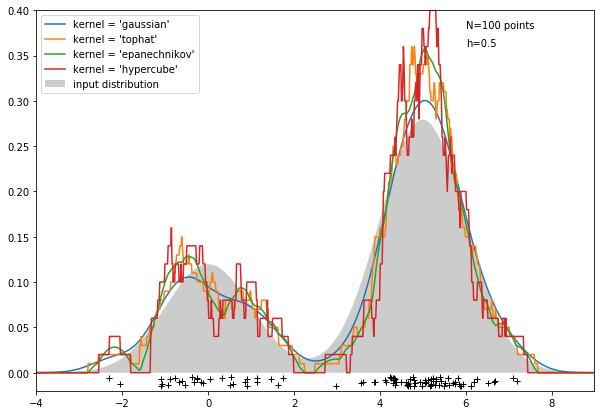

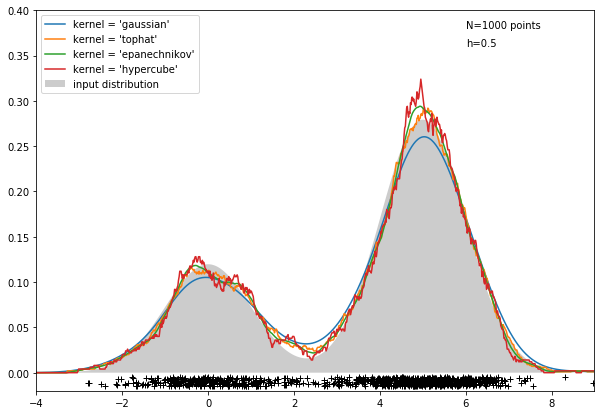

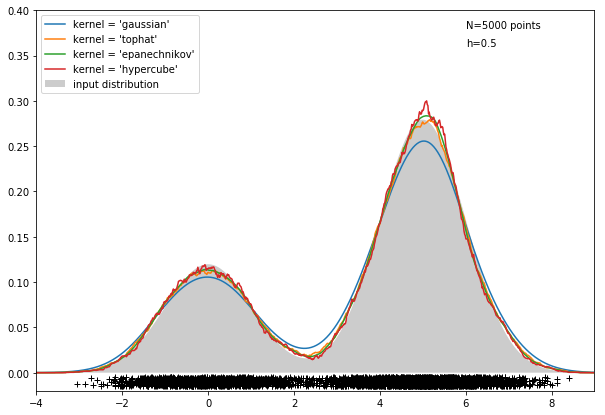

In [111]:
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

np.random.seed(1)
h = 0.5
for N in [100, 1000, 5000]:
    X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                        np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

    X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

    true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
                 + 0.7 * norm(5, 1).pdf(X_plot[:, 0])) #两个1维正态分布之和

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
            label='actual distribution')

    for kernel in ['gaussian', 'tophat', 'epanechnikov']:
        kde = KernelDensity(kernel=kernel, bandwidth=h).fit(X)
        log_dens = kde.score_samples(X_plot)
        ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
                label="kernel = '{0}'".format(kernel))    

    # Hypercube kernel
    Z = []
    for i in X_plot:
        Z.append(parzen_estimation(X, np.array([i]), h=h, d=1,
                                     window_func=parzen_window_func,
                                     kernel_func=hypercube_kernel))
    ax.plot(X_plot[:, 0], Z, '-',
            label="kernel = 'hypercube'") 

    ax.text(6, 0.38, "N={0} points".format(N))
    ax.text(6, 0.36, "h={0}".format(h))

    ax.legend(loc='upper left')
    ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

    ax.set_xlim(-4, 9)
    ax.set_ylim(-0.02, 0.4)
    plt.show()

固定N，改变h

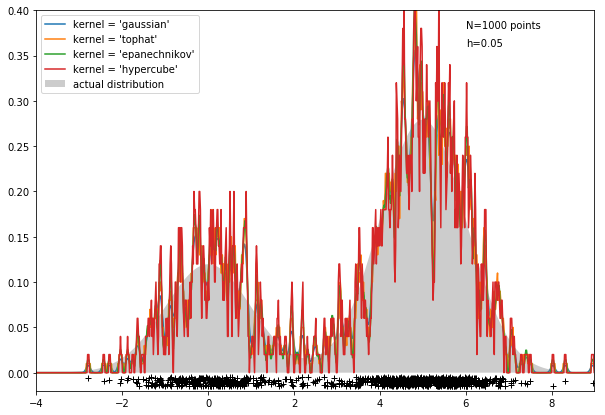

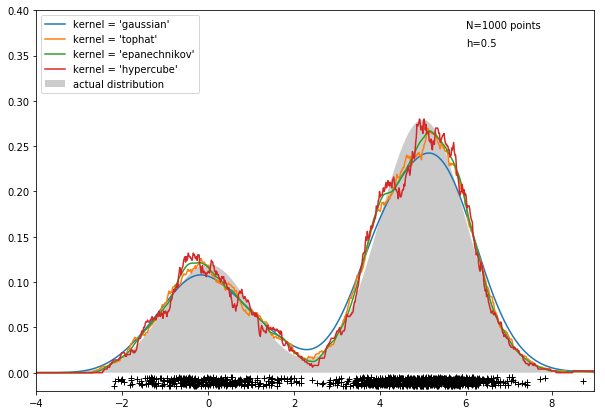

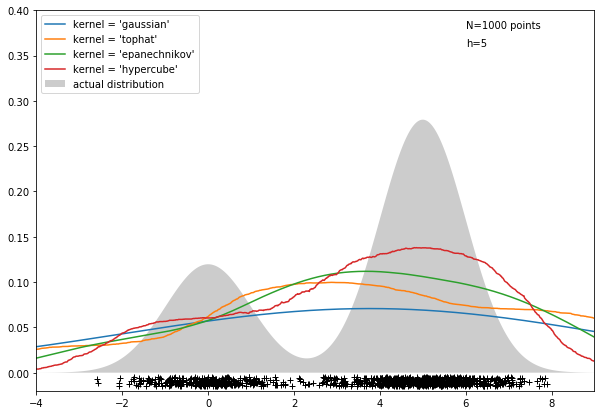

In [114]:
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

np.random.seed(1)
N = 1000
for h in [0.05, 0.5, 5]:
    X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                        np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

    X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

    true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
                 + 0.7 * norm(5, 1).pdf(X_plot[:, 0])) #两个1维正态分布之和

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
            label='actual distribution')

    for kernel in ['gaussian', 'tophat', 'epanechnikov']:
        kde = KernelDensity(kernel=kernel, bandwidth=h).fit(X)
        log_dens = kde.score_samples(X_plot)
        ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
                label="kernel = '{0}'".format(kernel))    

    # Hypercube kernel
    Z = []
    for i in X_plot:
        Z.append(parzen_estimation(X, np.array([i]), h=h, d=1,
                                     window_func=parzen_window_func,
                                     kernel_func=hypercube_kernel))
    ax.plot(X_plot[:, 0], Z, '-',
            label="kernel = 'hypercube'") 

    ax.text(6, 0.38, "N={0} points".format(N))
    ax.text(6, 0.36, "h={0}".format(h))

    ax.legend(loc='upper left')
    ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

    ax.set_xlim(-4, 9)
    ax.set_ylim(-0.02, 0.4)
    plt.show()

从上面两个对比实验，可以观察出样本越多，效果越好 同时h过小会导致过拟合，太大会导致欠拟合
另外也能看出来相对于另外几个方法，hypercube对样本数和h都更敏感，效果也相对较差

###下面是2维数据上的结果

In [101]:
from matplotlib.mlab import bivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')


def plot3d(X, Y, Z, title, N, h):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm,
        linewidth=0, antialiased=False)

    ax.set_zlim(0, 0.2)

    ax.zaxis.set_major_locator(plt.LinearLocator(10))
    ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('p(x)')
    ax.text(-5, -5, 0.25, "N={0} points".format(N))
    ax.text(-5, -5, 0.23, "h={0}".format(h))
    
    plt.title(title)

    fig.colorbar(surf, shrink=0.5, aspect=7, cmap=plt.cm.coolwarm)

    plt.show()

同样地，我们也先固定h，改变N，然后反过来
为了方便展示，这里只选择高斯核作为对比

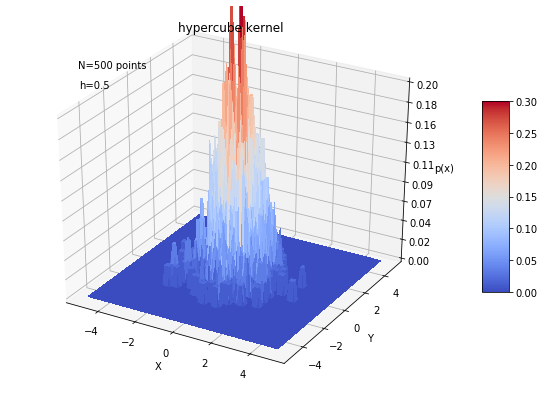

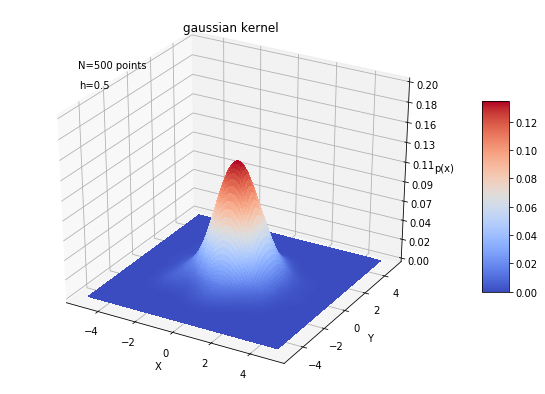

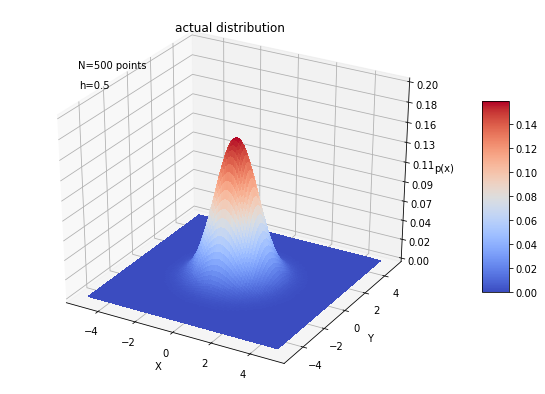

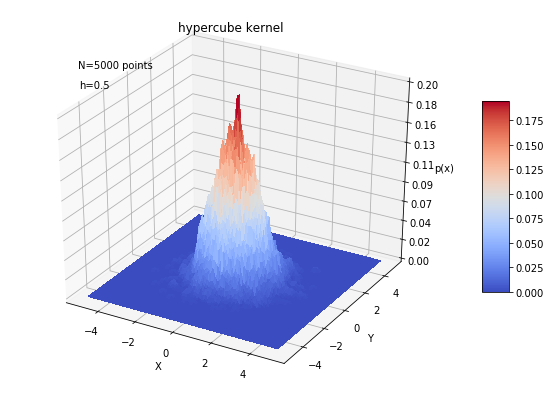

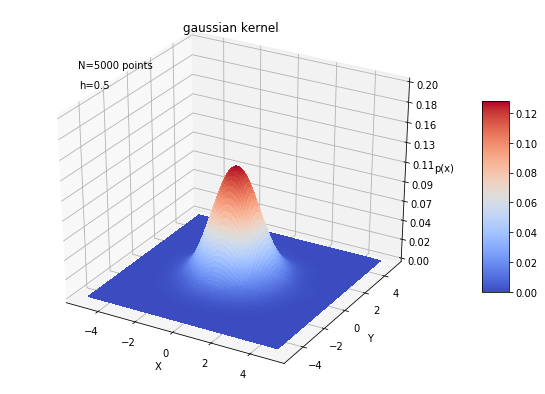

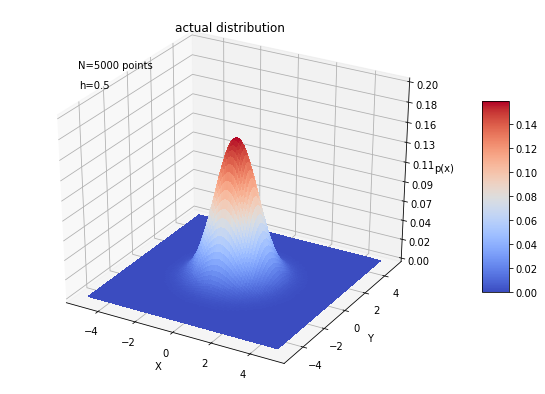

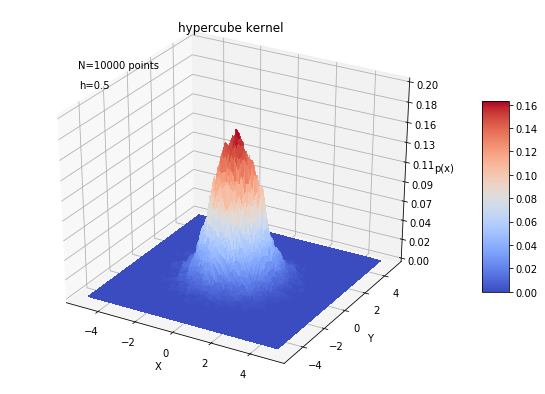

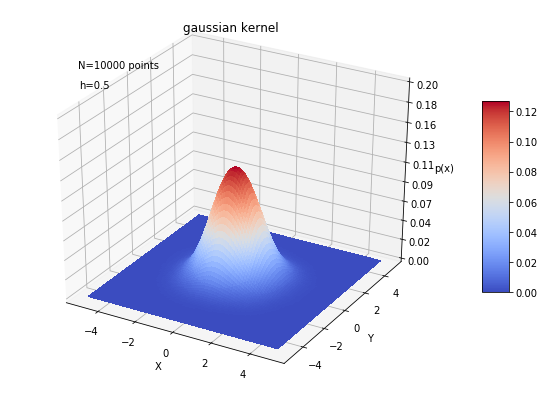

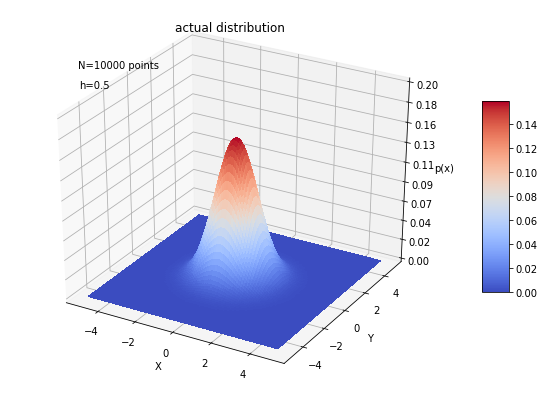

In [104]:
np.random.seed(1)
h = 0.5
for N in [500, 5000, 10000]:
    mu_vec = np.array([0,0])
    cov_mat = np.array([[1,0],[0,1]])
    x_2Dgauss = np.random.multivariate_normal(mu_vec, cov_mat, N) #二维正态分布

    X = np.linspace(-5, 5, 100)
    Y = np.linspace(-5, 5, 100)
    X,Y = np.meshgrid(X,Y)


    # Hypercube kernel

    Z = []
    for i,j in zip(X.ravel(),Y.ravel()):
        Z.append(parzen_estimation(x_2Dgauss, np.array([[i],[j]]), h=0.3, d=2,
                                     window_func=parzen_window_func,
                                     kernel_func=hypercube_kernel))
    Z = np.asarray(Z).reshape(100,100)
    plot3d(X, Y, Z, 'hypercube kernel', N, h)



    # Gaussian kernel

    for kernel in ['gaussian']:
        kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(x_2Dgauss)
        log_dens = kde.score_samples(np.array([X.ravel(),Y.ravel()]).T)
        Z = np.exp(log_dens)
        Z = Z.reshape(100,100)
        plot3d(X, Y, Z, '%s kernel' % kernel, N, h)



    # Actual

    Z = bivariate_normal(X, Y)
    plot3d(X, Y, Z, 'actual distribution', N, h)

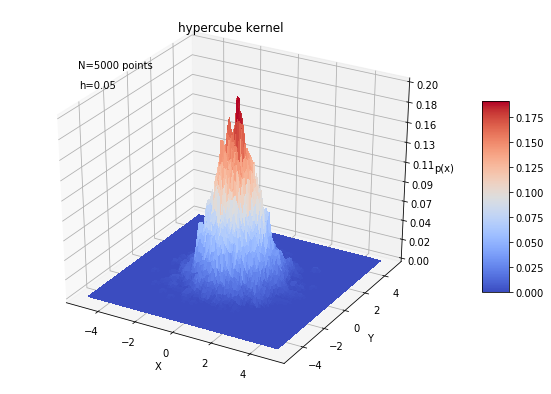

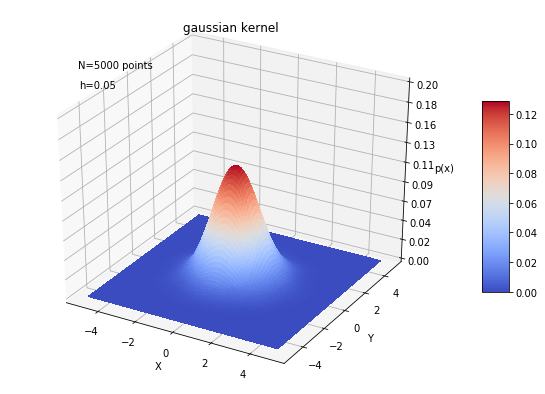

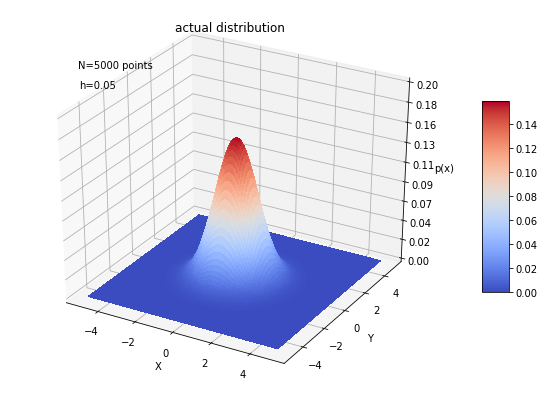

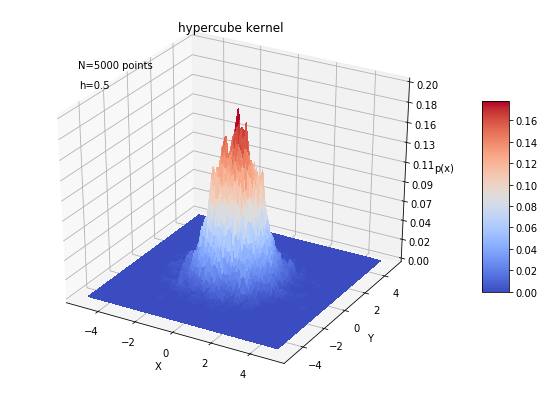

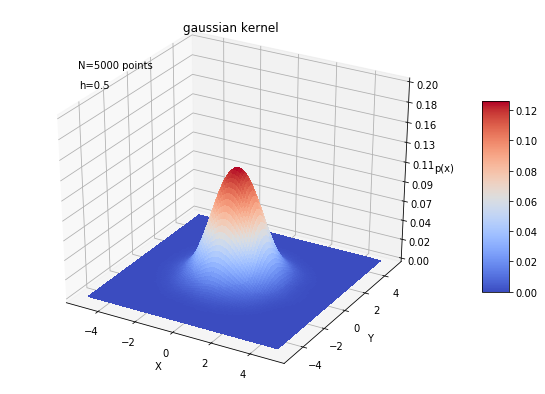

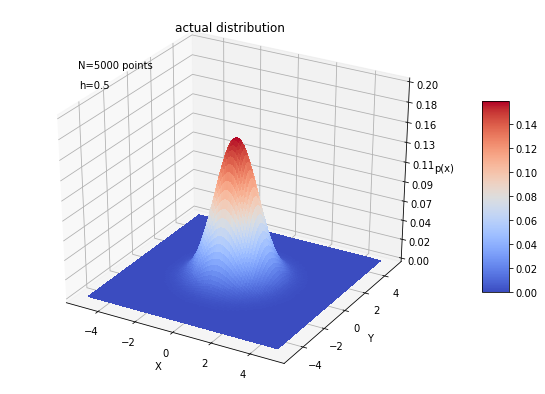

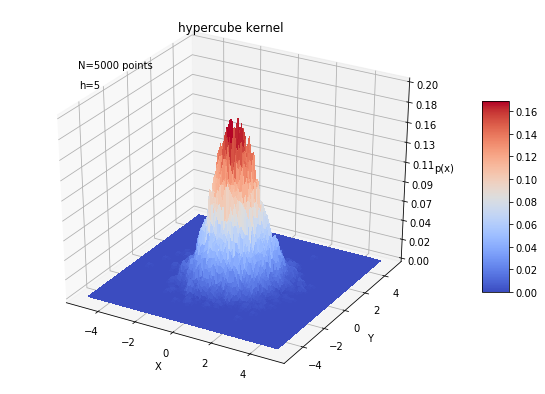

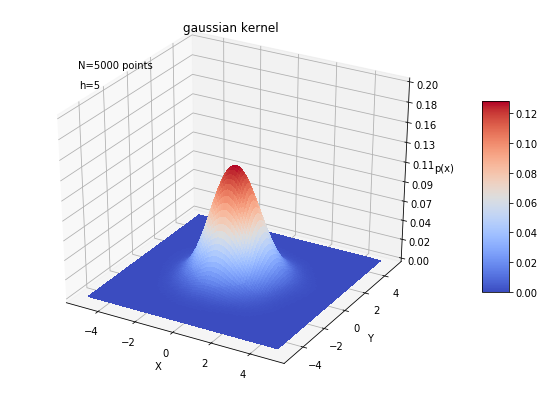

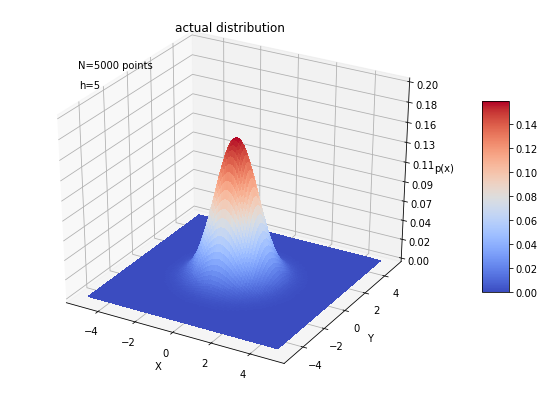

In [112]:
np.random.seed(1)
N = 5000
for h in [0.05, 0.5, 5]:
    mu_vec = np.array([0,0])
    cov_mat = np.array([[1,0],[0,1]])
    x_2Dgauss = np.random.multivariate_normal(mu_vec, cov_mat, N)

    X = np.linspace(-5, 5, 100)
    Y = np.linspace(-5, 5, 100)
    X,Y = np.meshgrid(X,Y)


    # Hypercube kernel

    Z = []
    for i,j in zip(X.ravel(),Y.ravel()):
        Z.append(parzen_estimation(x_2Dgauss, np.array([[i],[j]]), h=0.3, d=2,
                                     window_func=parzen_window_func,
                                     kernel_func=hypercube_kernel))
    Z = np.asarray(Z).reshape(100,100)
    plot3d(X, Y, Z, 'hypercube kernel', N, h)



    # Gaussian kernel

    for kernel in ['gaussian']:
        kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(x_2Dgauss)
        log_dens = kde.score_samples(np.array([X.ravel(),Y.ravel()]).T)
        Z = np.exp(log_dens)
        Z = Z.reshape(100,100)
        plot3d(X, Y, Z, '%s kernel' % kernel, N, h)



    # Actual

    Z = bivariate_normal(X, Y)
    plot3d(X, Y, Z, 'actual distribution', N, h)

###一些参考资料

[1] https://en.wikipedia.org/wiki/Kernel_density_estimation

[2] https://www.bauer.uh.edu/rsusmel/phd/ec1-26.pdf
    
[3] https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html

[4] https://github.com/rasbt/pattern_classification

[5] https://milania.de/blog/Introduction_to_kernel_density_estimation_%28Parzen_window_method%29
